In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
from datetime import date
pd.set_option("max_columns", None)

#### 1 - Reading in relevant dataset (outcomes by provider)

In [2]:
ds_dir = os.path.join(os.path.dirname(os.getcwd()), 'City of London Skills Review\Datasets')
file_path = os.path.join(ds_dir, 'Outcomes Success\pr02.csv')

otcms_by_prvdr = pd.read_csv(file_path, low_memory=False)

#### 2 - Formatting and filtering the dataset

In [3]:
def create_filters(df):
    c1 = df['AgeBand'] == 'Total'
    c2 = df['Gender'] == 'Total'
    c3 = df['Provision'] == 'Total'
    c4 = df['LevelOfLearning'] == 'Total'
    c5 = df['LearningDifficulties'] == 'Total'
    c6 = df['ProviderType'] == 'Total'
    filters = [c1, c2, c3, c4, c5, c6]
    return filters


def apply_filters(df, seg_ind, keep_total):
    filters = create_filters(df)
    if seg_ind == 'none':
        pass
    elif keep_total==True:
        filters.pop(seg_ind)
    else:
        df = df[~filters[seg_ind]]
        filters.pop(seg_ind)
    for f in filters:
        df = df[f]
    df.reset_index(drop=True, inplace=True)
    return df

def parse_data(df, seg_ind, keep_total):
    df.replace(to_replace = 'c', value=np.nan, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    for c in df.columns:
        if c in ['time_period', 'ProviderName']:
            df[c] = df[c].astype(str)
        else:
            try:
                df[c] = pd.to_numeric(df[c])
            except:
                pass
            
    filters = create_filters(df)
    df = apply_filters(df, seg_ind, keep_total)
    
    df = df[df['ProviderName'].notna()]
    df['ProviderName'].replace(to_replace=['ROYAL BOROUGH OF KINGSTON UPON THAMES', 'RICHMOND UPON THAMES LONDON BOROUGH COUNCIL'], 
                               value=['ROYAL BOROUGH OF KINGSTON UPON THAMES COUNCIL','RICHMOND UPON THAMES BOROUGH COUNCIL'],
                               inplace=True)
    
    unique_providers = pd.Series(df['ProviderName'].unique())
    searchfor = ['KINGSTON UPON THAMES', 'CROYDON', 'MERTON', 'RICHMOND UPON THAMES', 'WANDSWORTH', 'LAMBETH']

    comp_prv = list(unique_providers[np.logical_and(
                                                unique_providers.str.contains('|'.join(searchfor)), 
                                                unique_providers.str.contains('COUNCIL')
                                                )
                                    ]
                   )
    
    df = df[df['ProviderName'].isin(comp_prv)]
    df.reset_index(drop=True, inplace=True)
    
    # Simplify provider name for plot legends
    df['Provider'] = df['ProviderName'].apply(lambda x: x.split(' ')[3] if 'KINGSTON' in x else x.split(' ')[0])
    
    # Sorting values to have kingston appear first
    df['sort col'] = df['ProviderName'].apply(lambda x: 'A' if 'KINGSTON' in x else 'B')
    df = df.sort_values(by=['sort col', 'ProviderName', 'time_period'], ascending=True).reset_index(drop=True)
    
    return df

In [4]:
pr = parse_data(otcms_by_prvdr, 'none', True)

<ipython-input-3-498534e68525>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[f]


#### 3. Plotting

##### 3.1 Population Change

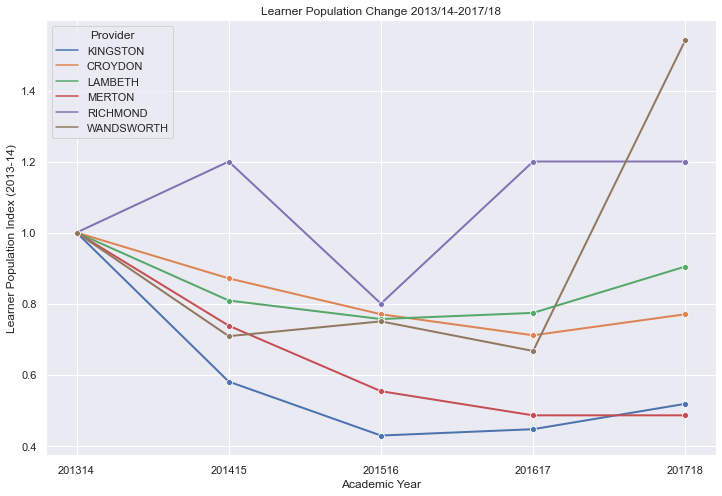

In [5]:
# Creating index population row
pr['index pop'] = np.nan
for p in pr['ProviderName'].unique():
    start_pop = int(pr[(pr['ProviderName'] == p)&(pr['time_period']=='201314')]['NumberOfLearners'])
    pr['index pop'] = np.where(pr['ProviderName']==p, pr['NumberOfLearners']/start_pop, pr['index pop'])

# Plotting results
fig = plt.figure(figsize=(12,8))
sns.set()
sns.set_context('notebook')

_ = sns.lineplot(data=pr, x = 'time_period', y='index pop', hue='Provider', marker='o', linewidth=2)
_ = plt.ylabel('Learner Population Index (2013-14)')
_ = plt.xlabel('Academic Year')
_ = plt.title('Learner Population Change 2013/14-2017/18')

plt.show()

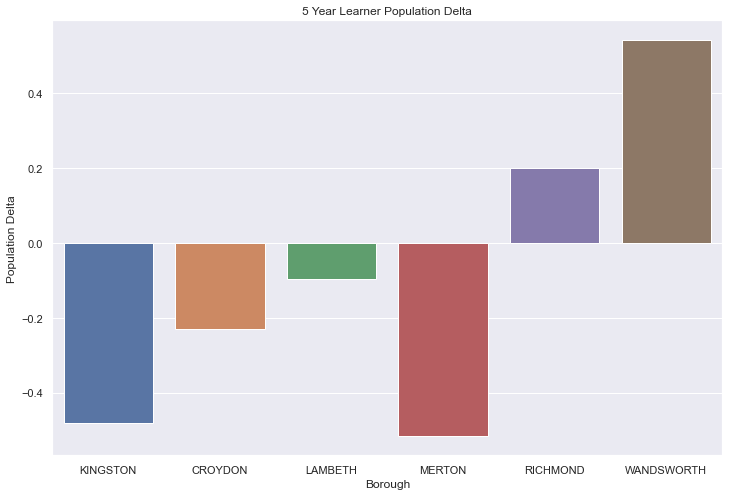

In [6]:
# Calculating 5 year pop delta
pd_5y = pr[pr['time_period'] == '201718'][['Provider', 'index pop']].reset_index(drop=True)
pd_5y['5y Delta'] = pd_5y['index pop']-1

fig = plt.figure(figsize=(12,8))

_ = sns.barplot(x='Provider', y = '5y Delta', data=pd_5y)
_ = plt.xlabel('Borough')
_ = plt.ylabel('Population Delta')
_ = plt.title('5 Year Learner Population Delta')
plt.show()

##### 3.2 Positive outcome rates

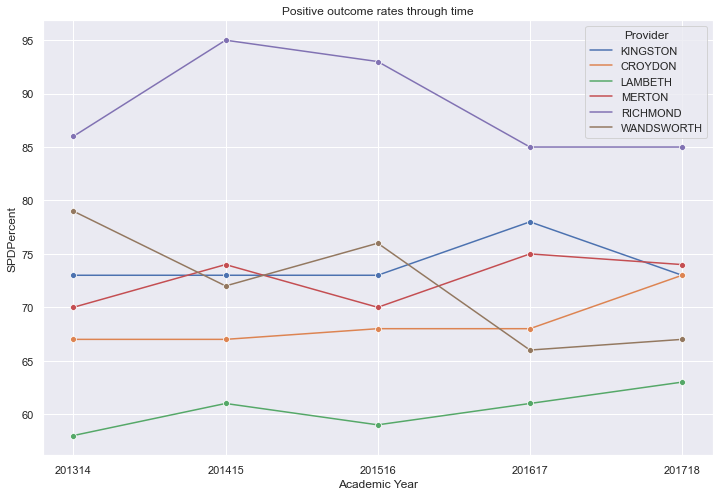

In [7]:
fig = plt.figure(figsize=(12,8))

_ = sns.lineplot(x='time_period', y='SPDPercent', data=pr, hue='Provider', marker='o')
_ = plt.title('Positive outcome rates through time')
_ = plt.xlabel('Academic Year')
_ = plt.ylabel('SPDPercent')

plt.show()

##### 3.2.1 Positive outcome rate split by type of outcome

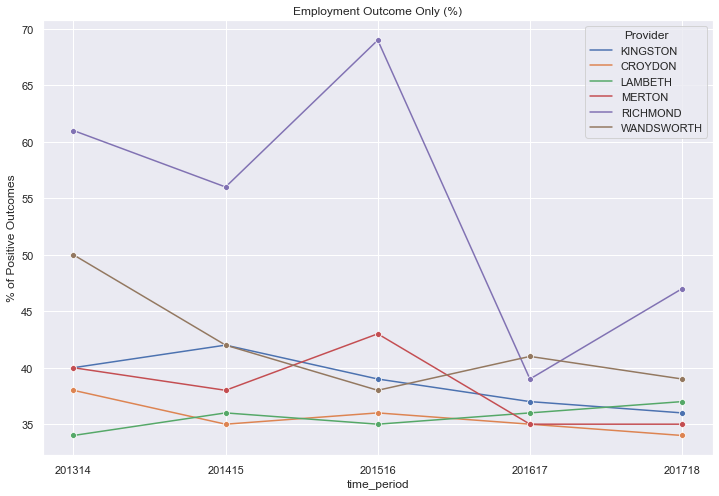

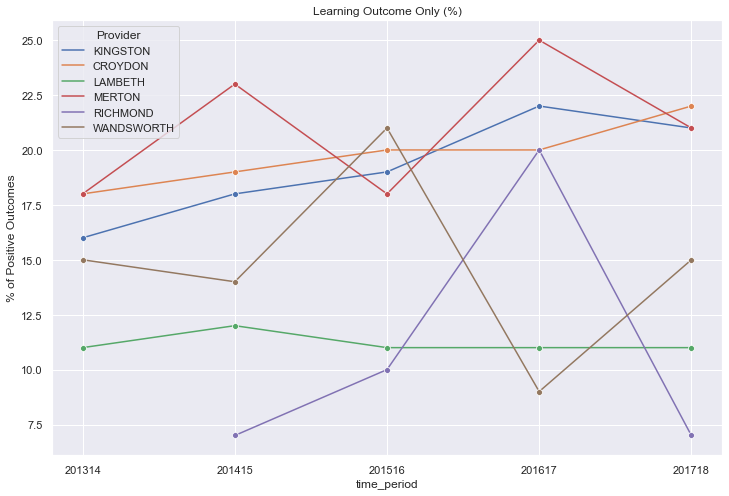

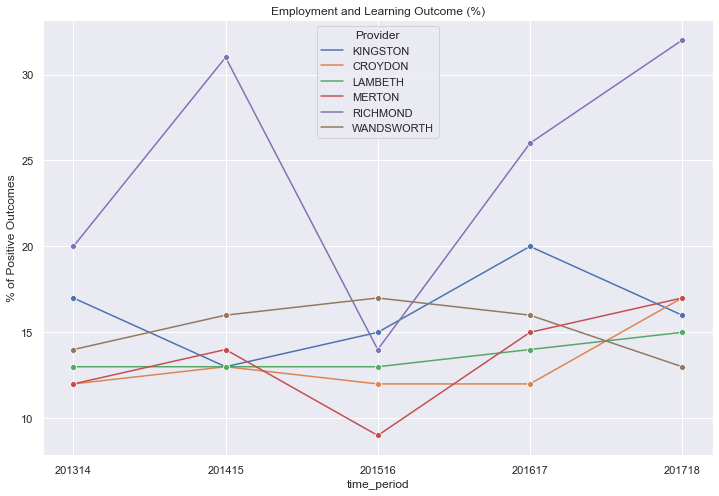

In [8]:
outcome_type = ['EmpOnlyPercent', 'LearnOnlyPercent', 'EmpAndLearnPercent']
# fig = plt.figure(figsize=(12,8))

for i, ot in enumerate(outcome_type):
    _ = plt.figure(figsize=(12,8))
#     plot_index = i+1
    _ = sns.lineplot(data=pr, x='time_period', y=ot, hue='Provider', marker='o')
    if i==0:
        _ = plt.title('Employment Outcome Only (%)')
    elif i==1:
        _ = plt.title('Learning Outcome Only (%)')
    else:
        _ = plt.title('Employment and Learning Outcome (%)')
    _ = plt.ylabel('% of Positive Outcomes')
    _ = plt.show()